In [1]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, ExperienceReplay, TWAP
import matplotlib.pyplot as plt

In [15]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True)

In [16]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [6]:
exp_replay = ExperienceReplay(capacity=10000)

In [7]:
from ddql_optimal_execution.trainer import Trainer

In [17]:
trainer = Trainer(agent, env, capacity=10000)

In [9]:
print(len(env.historical_data_series))

120


In [14]:
mem = trainer.exp_replay.memory

In [18]:
trainer.exp_replay.memory = mem

In [11]:
trainer.fill_exp_replay(max_steps=1000)

/Users/g0bel1n/DDQL-optimal-execution/ddql_optimal_execution/trainer/_trainer.py:73: MaxStepsTooLowWarning: Max steps is too low. It is set to 10000.
  warnings.warn(MaxStepsTooLowWarning(max_steps))
 40%|████      | 4029/10000 [00:49<01:13, 81.58it/s]


In [19]:
trainer.exp_replay.memory

array([ExperienceDict({'state': {'Price': 0.5378177187074084, 'volume': -0.2569438267854841, 'Trend': -0.1962333071071724, 'period': 0.0, 'QV': -0.8428167840414714, 'inventory': 500}, 'action': 0, 'reward': -20.870997013273573, 'next_state': {'Price': 0.48120427064921306, 'volume': -0.820344358936778, 'Trend': 0.12065975571920912, 'period': 1.0, 'QV': 0.5899712445949843, 'inventory': 500}, 'dist2Horizon': 4.0}),
       ExperienceDict({'state': {'Price': 0.48120427064921306, 'volume': -0.820344358936778, 'Trend': 0.12065975571920912, 'period': 1.0, 'QV': 0.5899712445949843, 'inventory': 500}, 'action': 0, 'reward': -889.5538593824018, 'next_state': {'Price': -1.6843759388696087, 'volume': 2.22263021830695, 'Trend': -1.211254571843905, 'period': 2.0, 'QV': -0.24196316058115214, 'inventory': 500}, 'dist2Horizon': 3.0}),
       ExperienceDict({'state': {'Price': -1.6843759388696087, 'volume': 2.22263021830695, 'Trend': -1.211254571843905, 'period': 2.0, 'QV': -0.24196316058115214, 'invento

In [20]:
trainer.pretrain(max_steps=1000, batch_size=32)

IndexError: index 500 is out of bounds for dimension 1 with size 500

In [11]:
for episode in range(len(env.historical_data_series)):
    env.swap_episode(episode)
    while not env.done:
        current_state = env.state.copy()
        action = agent(current_state)
        reward = env.step(action)

        distance2horizon = env.horizon - env.state["period"]
        exp_replay.push(current_state, action, reward, env.state.copy(), distance2horizon if distance2horizon <=1 else 2)
    
    #agent.learn(exp_replay.sample(128))

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [44]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
env.reset()

twap = TWAP( initial_budget=env.initial_inventory, horizon=env.horizon)

while not env.done:
    current_state = env.state.copy()
    action = twap(current_state)
    print(action)
    _ = env.step(action)
    pnl['twap'].append(env.state['Price']*action)

env.swap_episode(0)
while not env.done:
    current_state = env.state.copy()
    action = agent(current_state)
    print(action)
    _ = env.step(action)
    pnl['ddql'].append(env.state['Price']*action)






100
100
100
100
4
4
4
4


In [45]:
pnl

{'twap': [10032.831596704762,
  10057.83773444726,
  10077.65335403738,
  10077.65335403738],
 'ddql': [401.31326386819046,
  402.3135093778904,
  403.1061341614952,
  403.1061341614952]}

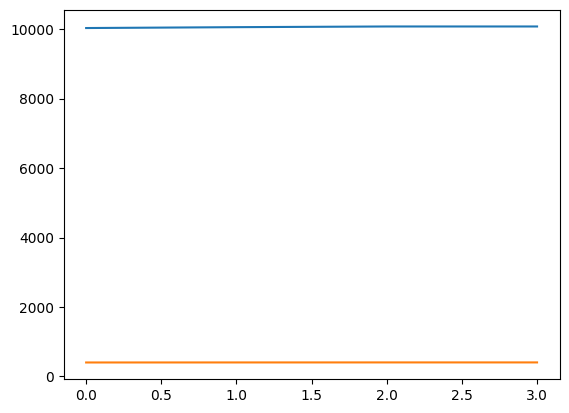

In [40]:
plt.plot(pnl['twap'], label='twap')
plt.plot(pnl['ddql'], label='ddql')

In [73]:
agent.learn(exp_replay.memory)

3


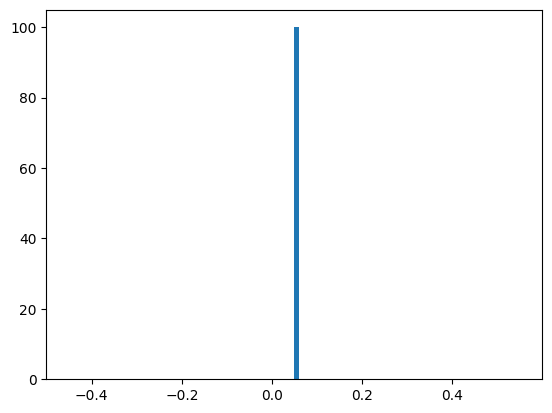

NameError: name 'np' is not defined

In [11]:
#distribution of rewards
plt.hist(rewards, bins=100, density=True)
plt.show()

print(f"mean reward: {np.mean(rewards)}")
print(f"std reward: {np.std(rewards)}")

In [6]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")